In [1]:
import sys
import re
import pickle
import os
import io
import torch
import numpy as np
import matplotlib.pyplot as plt

### Load data

In [2]:
## load the dictionary of top activations
run_name = 'out_autoencoder/1704783101.13-autoencoder-openwebtext'
dict_path = os.path.join(run_name, 'top_dict.pkl')

with open(dict_path, 'rb') as handle:
    top_dict = pickle.load(handle)
print(f'total number of autoencoder neurons: {len(top_dict)}')

total number of autoencoder neurons: 4096


In [3]:
## load model checkpoint 
ckpt_path = os.path.join(run_name, 'ckpt.pt')
ckpt = torch.load(ckpt_path, map_location='cpu')

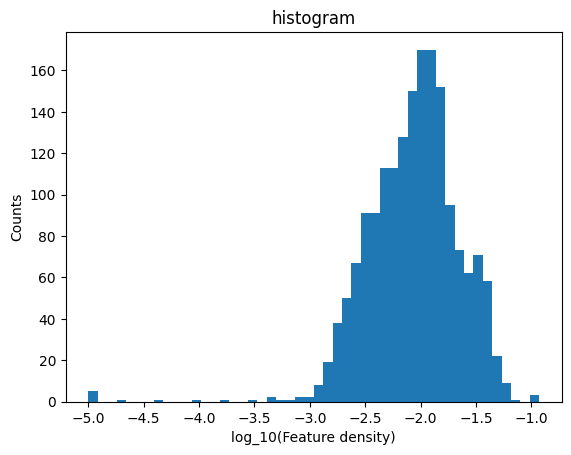

In [16]:
## plot feature density histogram again
eval_tokens = ckpt['config']['eval_tokens']
feature_activation_counts = ckpt['feature_activation_counts']
log_feature_activation_density = np.log10(feature_activation_counts[feature_activation_counts != 0]/(eval_tokens)) # (n_features,)
_, ax = plt.subplots()
ax.hist(log_feature_activation_density, bins='auto')
ax.set_title('Featude density histogram')
ax.set_xlabel('log_10(Feature density)')
ax.set_ylabel('Counts')

plt.show()

In [5]:
# Notice that the two modes seem to separate roughly around 1e-3 examples. 
modes_density_cutoff = 1e-3

# get top activations dictionary for high density neurons
high_density_neuron_indices = torch.arange(len(feature_activation_counts))[feature_activation_counts > modes_density_cutoff * eval_tokens]
high_density_neurons = {key:val for key, val in top_dict.items() if key in high_density_neuron_indices}
print(f'Number of high density neurons: {len(high_density_neurons)}')

# get top activations dictionary for ultra-low density neurons
ultra_low_density_indices = torch.arange(len(feature_activation_counts))[(feature_activation_counts != 0) & (feature_activation_counts < modes_density_cutoff * eval_tokens)]
ultra_low_density_neurons = {key:val for key, val in top_dict.items() if key in ultra_low_density_indices}
print(f'Number of ultra-low density neurons: {len(ultra_low_density_neurons)}')

dead_neuron_indices = torch.arange(len(feature_activation_counts))[(feature_activation_counts == 0)]
dead_neurons = {key:val for key, val in top_dict.items() if key in dead_neuron_indices}
print(f'Number of dead neurons: {len(dead_neurons)}')

print(f'Check that the total number of neurons matches up: {len(high_density_neurons) + len(ultra_low_density_neurons) + len(dead_neurons)}')

Number of high density neurons: 1755
Number of ultra-low density neurons: 17
Number of dead neurons: 2324
Check that the total number of neurons matches up: 4096


In [ ]:
high_density_neurons

### Print data to an HTML file

#### Some helper functions

In [6]:
def escape_html_preserve_br(text):
    #This function takes a string and replaces HTML special characters with their corresponding HTML entities
    #but preserves <br> as it is.
    # Replace all instances of <br> with a placeholder
    text = text.replace("<br>", "PLACEHOLDER_FOR_BR")
    # Dictionary of HTML special characters and their entities
    html_escape_table = {"&": "&amp;", '"': "&quot;", "'": "&apos;", ">": "&gt;", "<": "&lt;"}
    # Replace each special character with its corresponding HTML entity
    escaped_text = "".join(html_escape_table.get(c, c) for c in text)
    # Replace the placeholder with <br> again
    escaped_text = escaped_text.replace("PLACEHOLDER_FOR_BR", "<br>")
    return escaped_text

def special_print(mydict, manual_descriptions, sort=False):
    items = list(mydict.items())
    if sort: # if sort is True, sort neurons by their highest activation values
        items.sort(key=lambda x: x[1][0], reverse=True)
    output = "" # initiate a string that will contain all of the text
    for (neuron_id, list_of_activations_and_contexts) in items:
        output += f'<b> Neuron: {neuron_id} </b> <br> <br>  ' # for each neuron, give a header in

        # if we have a description for this neuron, add that
        if neuron_id in manual_descriptions: 
            output += f'<span style="color:blue;"> Common Theme: {manual_descriptions[neuron_id]}  </span> <br> <br>'

        # now get the contribution of current neuron to the string
        current_neuron_str = ""
        # update the current neuron string with contexts and activations for current neuron
        for activation, context in list_of_activations_and_contexts:
            current_neuron_str += f'{context} ; {activation:.4f} <br>'

        # if there is any HTML text in the current neuron string, make sure to replace it so that the HTML output is not disturbed
        for char in ["&", '"', "'", ">", "<"]:
            if char in current_neuron_str:
                current_neuron_str = escape_html_preserve_br(current_neuron_str)
                break
        output += current_neuron_str + '<br> <br> <hr> <br>'
    print(output)

def ansi_to_html(text):
    text = re.sub(r'\x1b\[91m', '<span style="color:red;">', text) # convert ANSI color codes to HTML
    text = re.sub(r'\x1b\[0m', '</span>', text)
    text = text.replace('\n', '&#x23CE;') # replace newline characters with HTML line breaks
    return text

#### Write down some manual descriptions [Optional]

I wrote these manual descriptions by analyzing the neuron. I used Claude and ChatGPT for help. Perhaps this step could be automated using Claude/ChatGPT APIs. 

In [7]:
manual_descriptions = {}
manual_descriptions[1] = 'Mention of a weapon or a vehicle in the context of a committed crime.'
manual_descriptions[2] = 'Military, government, and public service operations'
manual_descriptions[6] = 'Popular culture and entertainment'
manual_descriptions[9] = 'Political, social, and technological issues'
manual_descriptions[13] = 'Balancing constraints and optimization in various professional settings, focusing on managing costs, resources, and operational limitations.'
manual_descriptions[14] = 'Token-in-context: see' 
manual_descriptions[15] = 'Not clear'
manual_descriptions[16] = 'Token-in-context: thousands'
manual_descriptions[17] = 'Human names, mostly Middle Eastern/Arabic'
manual_descriptions[19] = 'Token-in-context: chance'
manual_descriptions[20] = 'Time in various contexts'
manual_descriptions[28] = "? or ! in dialogues with questions or exclamations, often reflecting surprise, skepticism, or strong emotion"
manual_descriptions[29] = "Services, opportunities, and activities in different sectors like business, arts, politics, and public amenities"
manual_descriptions[31] = "Global and political issues, focusing on strategies, challenges, and perspectives in international relations and security"
manual_descriptions[32] = 'Token-in-context: ch'
manual_descriptions[34] = 'Token-in-context: being'
manual_descriptions[38] = 'Token-in-context: Maybe'
manual_descriptions[39] = 'Token-in-context: also'
manual_descriptions[41] = 'Releasing or publishing content'
manual_descriptions[42] = 'Political figures and events, discussing various aspects of political strategy, legal actions, and opinions related to prominent personalities and policies.'

In [8]:
#### Can also update the manual descriptions dictionary with the help of a function that looks for token-in-context features.
# It essentially checks if the same 

def extract_red_text(input_string):
    pattern = r'\x1b\[91m[\s\S]*?\x1b\[0m' # pattern to match any characters including newlines between the red color markers
    match = re.search(pattern, input_string) # find the first occurrence of the pattern
    return match.group(0) if match else None # Return the matched text if found, otherwise return None

def update_manual_descriptions(mydict, manual_descriptions):
    output = ""
    for (neuron, list_activations) in mydict.items():
        # start with assuming that the red text is token in context
        check, token_in_context, prev_red_text = True, True, None  
        for index in range(len(list_activations)):
            current_red_text = extract_red_text(f'{list_activations[index][1]}')
            if check:
                if prev_red_text and current_red_text != prev_red_text: # if the previous red text is not the same as the current red text, we will not check again
                    token_in_context, check = False, False
            prev_red_text = current_red_text
        
        if token_in_context: # if token in context, update manual_descriptions
            manual_descriptions[neuron] = "Token-in-context: " + current_red_text[5:-4]
    return manual_descriptions

#### Use these functions to publish HTML

In [15]:
current_dict = ultra_low_density_neurons
sort_by_activations = False
if sort_by_activations:
    file_name = 'sorted_high_density_neurons' if current_dict == high_density_neurons else 'sorted_ultra_low_density_neurons' if current_dict == ultra_low_density_neurons else 'sorted_dead_neurons'
else: 
    file_name = 'high_density_neurons' if current_dict == high_density_neurons else 'ultra_low_density_neurons' if current_dict == ultra_low_density_neurons else 'dead_neurons'

manual_descriptions = update_manual_descriptions(high_density_neurons, manual_descriptions)

# Write the content to an HTML file
with open(os.path.join(run_name, f'{file_name}.html'), 'w') as file:
    original_stdout = sys.stdout 
    # Capture the output of special_print directly into a string
    output_stream = io.StringIO()
    sys.stdout = output_stream  # Redirect stdout to the StringIO object
    special_print(current_dict, manual_descriptions, sort=sort_by_activations)  # Call the function
    sys.stdout = original_stdout  # Reset stdout to its original value

    # The captured output is now in output_stream
    captured_output = output_stream.getvalue()
    html_content = f"""<!DOCTYPE html>
    <html>
    <head>
        <title>{file_name}</title>
    </head>
    <body>
        <p>{ansi_to_html(captured_output)}</p>
    </body>
    </html>"""
    file.write(html_content)